In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [19]:
import torch
from torchvision import datasets
import webdataset as wds
from PIL import Image, ImageDraw, ImageFont

# Writing MNIST as Shards

In [9]:
mnist = datasets.MNIST(root="./data", download=True, train=True)

In [14]:
sink = wds.ShardWriter(pattern="mnist-%06d.tar")
for i, (image, cls) in enumerate(mnist):
    sink.write({
        "__key__": f"{i:06d}",
        "png": image,
        "cls": cls
    })
sink.close()

# writing mnist-000000.tar 0 0.0 GB 0


In [15]:
!ls -lh mnist-000000.tar

-rw-rw-r-- 1 tmb tmb 235M Aug 26 03:27 mnist-000000.tar


In [16]:
!tar tvf mnist-000000.tar | sed 5q

-r--r--r-- bigdata/bigdata   1 2021-08-26 03:27 000000.cls
-r--r--r-- bigdata/bigdata 313 2021-08-26 03:27 000000.png
-r--r--r-- bigdata/bigdata   1 2021-08-26 03:27 000001.cls
-r--r--r-- bigdata/bigdata 312 2021-08-26 03:27 000001.png
-r--r--r-- bigdata/bigdata   1 2021-08-26 03:27 000002.cls
tar: write error


# Generate a Large Rendered Dataset

In [29]:
!curl -sL https://filesamples.com/samples/font/ttf/OpenSans-Regular.ttf > OpenSans-Regular.ttf
!curl -sL https://raw.githubusercontent.com/dwyl/english-words/master/words.txt > words.txt

In [30]:
!head words.txt

2
1080
&c
10-point
10th
11-point
12-point
16-point
18-point
1st


Use the Pillow library to render text (or figure out how to do this with Cairo).

See here for more information: https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html

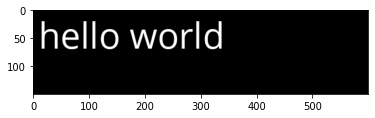

In [31]:
fontsize = 64
image = Image.new("RGB", (600,150), (0, 0, 0))
draw = ImageDraw.Draw(image)
font = ImageFont.truetype("OpenSans-Regular.ttf", fontsize)
draw.text((10, 0), "hello world", (255,255,255), font=font)
a = np.asarray(image)
imshow(a)

Part 1:

- use random samples from words.txt as text
- use ImageDraw / ImageFont to generate images corresponding to the words
- write sharded training data; your training data should contain:
    - images with .jpg extension
    - ground truth text with .gt.txt extension
    - metainfo about the font name and font size with .json extension
    
Follow the MNIST example above to see how you can write.

In [34]:
def generate_word_training_data(output, num_samples, pattern, wordfile, fontlist, ):
    sink = wds.TarWriter(output, ...)
    for i in range(num_samples):
        ...
        sink.write(...)
        ...
    sink.close()

Part 2:
- write `ray` code to generate 20 shards in parallel (use `multiprocessing` if you can't use `ray`)

# Write an Image Augmentation Tool

The main function should look something like:

In [35]:
def augment_image(image):
    return ...

def augment_shard(source_url, output, extension="jpg"):
    source = wds.WebDataset(source_url, ...)
    sink = wds.TarWriter(output, ...)
    for sample in source:
        result = dict(sample)
        result[extension] = augment(sample[extension])
        sink.write(...)

Exercise:

- write `ray` code to augment a list of shards in parallel (use `multiprocessing` if you can't use `ray`)
- wrap up your code in a script using a command line library (`argparse` or [`typer`](https://pypi.org/project/typer/))
- write a shell script to run your script over the 20 shards you generated above

Optional:

- follow the Kubernetes example from the lecture to schedule the 20 shard transformations as Kubernetes Jobs